In [1]:
import pandas as pd
import scipy
import matplotlib
import matplotlib.colors as mcolors
import os 

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
import glob
from scipy.spatial.distance import squareform
import numpy as np
import networkx as nx
from graspologic.match import graph_match
from sklearn import datasets, manifold
from matplotlib.pyplot import cm
import seaborn as sns
from adjustText import adjust_text

from scipy import cluster


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
from module.utils import load_object, get_neighbourhood, get_w_threshold

In [3]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance, combine_vecs
from module.gramchd.nhood import get_io_top_NM
from module.gramchd.nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output
from module.Ceval.dendrogram_eval import get_clustering_stats

In [4]:
import pandas as pd

from module.denclex.dendrograms_plotting import get_network_from_tree, get_adj_from_edgelist, generate_cluster_evolution
from module.denclex.tree_network import tree_search


In [ ]:
datadate = '20231124'
nb_name = '02_ctpurity_stats'
save_things = False


In [6]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})


vnc_meta.bodyId = vnc_meta.bodyId.astype('str')


In [7]:
heminames = ['13B', '23B', '14A'] # sample hemilineages
n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values))
# n_ids = nexist_ids # all by all
n_ids = sorted(n_ids)[:]


## Get dfs

In [8]:
Ms = [30,50,80,100]
msize_dist_df = {}
for M in Ms:
    jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

    fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
    files = glob.glob(fpath_prefix)
    hemis_M_ew_dist_df = combine_vecs(fpath_prefix)
    hemis_M_ew_dist_df = hemis_M_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)
    msize_dist_df[M] = hemis_M_ew_dist_df

In [9]:
ind_to_id = [str(i) for i in n_ids]
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()


In [ ]:
cluster_stats = {}

for M in Ms:
    dist_df = msize_dist_df[M]
    dist_type = 'euclidean_distance'
    method='ward'
    cond_dist = (dist_df[dist_type].values)
    Z = linkage(cond_dist, method=method) 
    
    stat_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
    cluster_stats[M] = stat_df

# ~3mins

In [11]:
total_purities = []
total_mean_pmses = []
for M in Ms:
    stat_df = cluster_stats[M]
    purity = stat_df.m_p.sum()/stat_df.len.sum()
    mean_pms = stat_df.pms.mean()
    total_purities.append(purity)
    total_mean_pmses.append(mean_pms)

In [12]:
hemitype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage').bodyId.apply(list).to_dict()

In [13]:
hemitype_to_ctype = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage')['type'].apply(list).to_dict()

In [14]:
cell_type_split = {}
for key, val in hemitype_to_leaf.items():
    purities = []
    mean_pmses = []
    ctype_ids = hemitype_to_ctype.get(key)

    for M in Ms:
        stat_df = cluster_stats[M].query('labels.isin(@ctype_ids)')
        purity = stat_df.m_p.sum()/stat_df.len.sum()
        mean_pms = stat_df.pms.mean()
        purities.append(purity)
        mean_pmses.append(mean_pms)
    cell_type_split[key] = (purities, mean_pmses)

In [15]:
# plt.figure(figsize=(5,4))
# plt.plot(Ms, total_purities, 'o-', label='All')
# for key, val in cell_type_split.items(): 
#     purities = val[0]
#     plt.plot(Ms, purities, 'o-', alpha=0.8, label=key) 
# plt.legend()
# plt.xlabel('Neighbourhood size', size=15)
# plt.ylabel('Cell type purity coverage', size=15)
# plt.tight_layout()
# plt.xlim([25,105])
# plt.ylim([0.35, 0.68])
# sns.despine(offset=0.5, trim=True)
# plt.show()

In [16]:
# plt.figure(figsize=(5,4))
# plt.plot(Ms, total_mean_pmses, 'o-', label='All')
# for key, val in cell_type_split.items(): 
#     mean_pmses = val[1]
#     plt.plot(Ms, mean_pmses, 'o-', alpha=0.8, label=key) 
# plt.legend()
# plt.xlabel('Neighbourhood size', size=15)
# plt.ylabel('Mean cell type tightness', size=15)
# plt.tight_layout()
# # plt.xlim([25,105])
# plt.ylim([0.2, 0.35])
# sns.despine(offset=0.5, trim=True)
# plt.show()

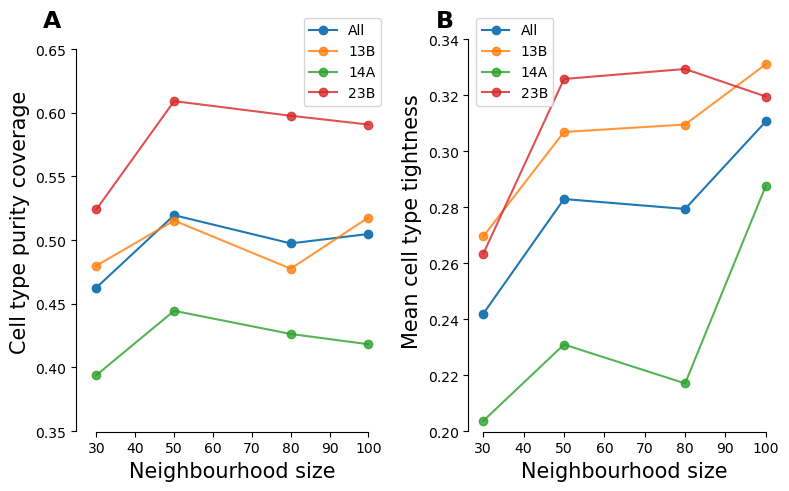

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

ax1, ax2 = ax
# plt.figure(figsize=(5,4))
ax1.plot(Ms, total_purities, 'o-', label='All')
for key, val in cell_type_split.items(): 
    purities = val[0]
    ax1.plot(Ms, purities, 'o-', alpha=0.8, label=key) 
ax1.legend()
ax1.set_xlabel('Neighbourhood size', size=15)
ax1.set_ylabel('Cell type purity coverage', size=15)
plt.tight_layout()
ax1.set_xticks(np.arange(30, 110, 10))
ax1.set_xlim([25,105])
ax1.set_ylim([0.35, 0.68])
sns.despine(offset=0.5, trim=True, ax=ax1)



ax2.plot(Ms, total_mean_pmses, 'o-', label='All')
for key, val in cell_type_split.items(): 
    mean_pmses = val[1]
    ax2.plot(Ms, mean_pmses, 'o-', alpha=0.8, label=key) 
ax2.legend()
ax2.set_xlabel('Neighbourhood size', size=15)
ax2.set_ylabel('Mean cell type tightness', size=15)
plt.tight_layout()
ax2.set_xticks(np.arange(30, 110, 10))

# plt.xlim([25,105])
ax2.set_ylim([0.2, 0.35])
sns.despine(offset=0.5, trim=True)

for ax, text in zip([ax1,ax2], 'AB'):
    ax.text(-0.05, 0.95, text, transform=ax.transAxes, fontsize=17, fontweight='bold', va='bottom',  ha='right')

# save_things = False
if save_things: 
    plt.savefig(f'../figures/{nb_name}/ctpurity_stats.png', transparent=True, bbox_inches='tight', dpi=300)
    plt.savefig(f'../figures/{nb_name}/ctpurity_stats.pdf', transparent=True, bbox_inches='tight', dpi=300)
plt.show()